# betelbot

This notebook is a modified version of code from [betelbot](https://github.com/hippke/betelbot) by Michael Hippke.

Copyright 2020 Allen Downey
[MIT License](https://opensource.org/licenses/MIT)

In [ ]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [1]:
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import requests
from bs4 import BeautifulSoup

from astropy.stats import biweight_location

In [2]:
def get_mags_from_AAVSO(url, params):
    """Read a table from AAVSO.
    
    url: base URL
    params: dictionary of parameters
    
    returns: DataFrame
    """
    r = requests.get(url, params=params)
    print(r.url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    # make the dataframe
    columns = ['mag', 'band']
    df = pd.DataFrame(columns=columns, dtype=float)
    
    # read the table rows
    rows = soup.select('tr')
    for row in rows:
        string = '' + row.text
        t = string.split('\n')
        if len(t) == 12:
            date = float(t[3])
            mag = float(t[5])
            band = t[7]
            df.loc[date] = mag, band
            
    return df

In [3]:
# get the CCD magnitudes
url = 'https://www.aavso.org/apps/webobs/results/'

params = {'star': 'betelgeuse',
          'num_results': 100,
          'obs_types': 'dslr ccd',
          'page': 1}

df = get_mags_from_AAVSO(url, params)
df.head()

https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=100&obs_types=dslr+ccd&page=1


,mag,band
2.458965e+06,0.983,TB
2.458964e+06,1.502,TB
2.458963e+06,0.456,V
2.458963e+06,0.409,V
2.458963e+06,0.410,V


In [4]:
def get_recent_mag(df, days):
    """Select recent measurements.
    
    df: DataFrame
    days: number of days to collect

    returns: Series of magnitudes
    """
    mags = df['mag'].copy()
    mags.index -= mags.index.max()
    recent = (mags.index >= -days)
    return mags[recent]

Select recent measurements with band V (visible light?)

In [5]:
band_v = (df['band'] == 'V')
ccd_obs20 = get_recent_mag(df[band_v], 20)

The following function uses LOWESS to smooth the timeseries.

In [6]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [7]:
def decorate():
    """Add labels to the axes.
    """
    plt.xlabel('Days before today')
    plt.ylabel('Visual magnitude')

    mid = 1.0
    plt.ylim(mid-1, mid+1)
    
    # why are we inverting the y axis?
    plt.gca().invert_yaxis()

Plot the CCD data

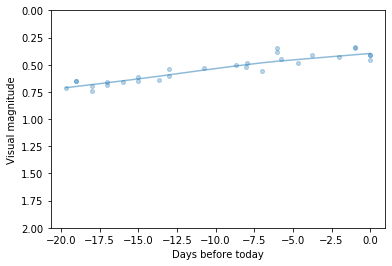

In [8]:
ccd_obs20.plot(style='o', markersize=4, alpha=0.3)

smooth = make_lowess(ccd_obs20)
smooth.plot(color='C0', alpha=0.5)

decorate()

## Visual data

In [9]:
url = 'https://www.aavso.org/apps/webobs/results/'

params = {'star': 'betelgeuse',
          'num_results': 200,
          'obs_types': 'vis',
          'page': 1}

vis = get_mags_from_AAVSO(url, params)
vis.head()

https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=1


,mag,band
2.458982e+06,0.52,Vis.
2.458982e+06,0.54,Vis.
2.458981e+06,0.55,Vis.
2.458981e+06,0.50,Vis.
2.458980e+06,0.50,Vis.


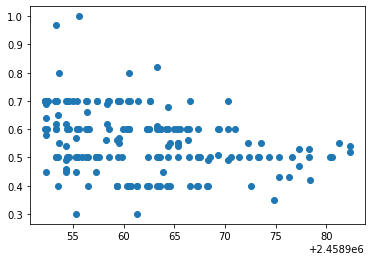

In [10]:
vis['mag'].plot(style='o')

In [11]:
# read the first 5 pages

pages = np.arange(1, 6)
df_seq = []
for page in pages:
    params['page'] = page
    df = get_mags_from_AAVSO(url, params)
    df_seq.append(df)

https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=1
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=2
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=3
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=4
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=5


Concatenate the pages into a single DataFrame

In [12]:
vis = pd.concat(df_seq)
vis.head()

,mag,band
2.458982e+06,0.52,Vis.
2.458982e+06,0.54,Vis.
2.458981e+06,0.55,Vis.
2.458981e+06,0.50,Vis.
2.458980e+06,0.50,Vis.


Select the last 20 days and plot the data.

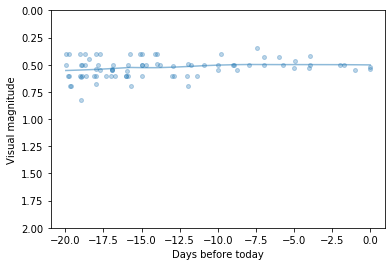

In [13]:
vis_obs20 = get_recent_mag(vis, 20)
vis_obs20.plot(style='o', markersize=4, alpha=0.3)

smooth = make_lowess(vis_obs20)
smooth.plot(color='C0', alpha=0.5)

decorate()

In [14]:
def make_plot(ccd_obs, vis_obs):
    """
    """

    smooth = make_lowess(vis_obs20)
    smooth.plot(color='C0', alpha=0.5)

    vis_obs20.plot(style='o', markersize=4, alpha=0.3)
    ccd_obs20.plot(style='o', markersize=4, alpha=0.3)

    decorate()

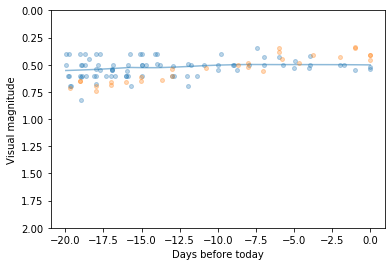

In [15]:
make_plot(ccd_obs20, vis_obs20)

In [16]:
date_text = datetime.datetime.now().strftime("%d %b %Y")
date_text

'13 May 2020'

In [17]:
last24hrs = (vis_obs20.index >= -1)
data = vis_obs20[last24hrs]
mean_last24hrs = biweight_location(data)
mean_last24hrs

0.53

In [18]:
lumi = str(format(mean_last24hrs, '.2f'))
lumi

'0.53'

In [19]:
s = f'#Betelgeuse brightness {lumi} mag on {date_text} by @betelbot'
s

'#Betelgeuse brightness 0.53 mag on 13 May 2020 by @betelbot'

In [20]:
def build_string(days_ago, mag):
    print('Building string...')
    data_last24hrs = np.where(days_ago<1)
    data_last1_6_days = np.where((days_ago<6) & (days_ago>1))
    n_obs_last24hrs = np.size(mag[data_last24hrs])
    n_obs_last1_6_days = np.size(mag[data_last1_6_days])
    mean_last24hrs = biweight_location(mag[data_last24hrs])
    mean_last1_6_days = biweight_location(mag[data_last1_6_days])
    stdev = np.std(mag[data_last24hrs]) / np.sqrt(n_obs_last24hrs) \
        + np.std(mag[data_last1_6_days]) / np.sqrt(n_obs_last1_6_days)
    diff = mean_last24hrs - mean_last1_6_days
    sigma = diff / stdev

    if n_obs_last24hrs < 1 or n_obs_last1_6_days < 2:
        print('Not enough observations. Abort.')
        return None
    else:

        if diff > 0:
            changeword = 'dimmer'
        else:
            changeword = 'brighter'

        mag_text = "My visual mag from last night was " + \
            str(format(mean_last24hrs, '.2f')) + \
            ' (robust mean of ' + \
            str(n_obs_last24hrs) + \
            ' observations). '

        change_text = 'That is ' + \
            format(abs(diff), '.2f') + \
            ' mag ' + \
            changeword + \
            ' than the robust mean of the 5 previous nights (n=' + \
            str(n_obs_last1_6_days) + \
            ', ' + \
            format(abs(sigma), '.1f') + \
            'σ). #Betelgeuse'

        text = mag_text + change_text
        print(text)
        return text


## Use pandas.read_html?

Pandas can parse the HTML and make a DataFrame, but the result is kind of a mess.  We're probably better off with BeautifulSoup.

In [21]:
url = 'https://www.aavso.org/apps/webobs/results/'

params = {'star': 'betelgeuse',
          'num_results': 200,
          'obs_types': 'dslr ptg pep ccd visdig',
          'page': 1}

In [22]:
import requests

r = requests.get(url, params=params)

In [23]:
r.text

'<!DOCTYPE html>\n<html lang=\'en\'>\n  <head>\n    \n    <title>AAVSO -- WebObs Search Results</title>\n    <meta http-equiv="Content-Type" content=\'text/html; charset=utf-8\' />\n\n    <!-- css includes -->\n    \n\n      <link href="/static/compressed/css/base.ba6c58564962.css" rel="stylesheet" type="text/css" media="screen" />\n      <link href="/static/compressed/css/print.b055ce91ad2d.css" rel="stylesheet" type="text/css" media="print" />\n    \n<style type="text/css">\np#obsinfo {\n    font-weight: bold;\n    font-size: 1.1em;\n}\n#obsinfo strong {\n    font-weight: bold;\n    font-style: italic;\n    color: green;\n}\n</style>\n\n\n    <!-- js includes -->\n    \n\n      <script type="text/javascript" src="/static/compressed/js/base.3f50618b9299.js" charset="utf-8"></script>\n    \n<script type="text/javascript" src="/static/compressed/js/webobs.5a9abd7df356.js" charset="utf-8"></script>\n\n\n    <!-- Google Analytics Tag -->\n    <script>\n(function(i,s,o,g,r,a,m){i[\'GoogleA

In [24]:
import pandas as pd
tables = pd.read_html(r.text)

In [25]:
len(tables)

201

In [26]:
table = tables[0]
table.columns

MultiIndex([( 'Unnamed: 0_level_0',           'Comp Star', ...),
            ( 'Unnamed: 1_level_0',          'Check Star', ...),
            ( 'Unnamed: 2_level_0',         'Transformed', ...),
            (               'Star',               'Chart', ...),
            (                 'JD',       'Comment Codes', ...),
            (      'Calendar Date',               'Notes', ...),
            (          'Magnitude',  'Unnamed: 6_level_1', ...),
            (              'Error',  'Unnamed: 7_level_1', ...),
            (             'Filter',  'Unnamed: 8_level_1', ...),
            (           'Observer',  'Unnamed: 9_level_1', ...),
            ('Unnamed: 10_level_0', 'Unnamed: 10_level_1', ...)],
           )

## Use the API

Using the API and getting JSON would be better than parsing HTML, but it looks like the API works with a different dataset.

In [27]:
url = 'https://www.aavso.org/apps/vsp/api/chart/'

In [28]:
params = {'format': 'json',
          'star': 'SS Cyg',
          'fov': 60,
          'maglimit': 14.5}

In [29]:
import requests

r = requests.get(url, params=params)

In [30]:
json = r.json()
json

{'comment': '',
 'star': 'SS Cyg',
 'maglimit': 14.5,
 'special': None,
 'auid': '000-BCP-220',
 'fov': 60.0,
 'dec': '43:35:09.9',
 'title': '',
 'dss': False,
 'chartid': 'X25365CNR',
 'image_uri': 'https://www.aavso.org/apps/vsp/chart/X25365CNR.png',
 'ra': '21:42:42.79',
 'photometry': [{'auid': '000-BCP-115',
   'bands': [{'band': 'V', 'mag': 5.11, 'error': 0.0},
    {'band': 'U', 'mag': 8.61, 'error': 0.0},
    {'band': 'B', 'mag': 6.71, 'error': 0.0},
    {'band': 'J', 'mag': 2.137, 'error': 0.0},
    {'band': 'H', 'mag': 1.225, 'error': 0.0},
    {'band': 'K', 'mag': 1.082, 'error': 0.0}],
   'comments': 'BINO_COMP',
   'label': 51,
   'ra': '21:40:11.11',
   'dec': '43:16:25.8'},
  {'auid': '000-BCP-283',
   'bands': [{'band': 'V', 'mag': 7.709, 'error': 0.174},
    {'band': 'B', 'mag': 9.436, 'error': 0.178},
    {'band': 'Ic', 'mag': 5.577, 'error': 0.267},
    {'band': 'J', 'mag': 4.103, 'error': 0.262},
    {'band': 'H', 'mag': 3.225, 'error': 0.222},
    {'band': 'K', 'ma

In [31]:
pd.read_json(r.text)

,comment,star,maglimit,special,auid,fov,dec,title,dss,chartid,image_uri,ra,photometry,resolution
0,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-115', 'bands': [{'band': 'V'...",150
1,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-283', 'bands': [{'band': 'V'...",150
2,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-235', 'bands': [{'band': 'V'...",150
3,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-261', 'bands': [{'band': 'V'...",150
4,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-245', 'bands': [{'band': 'V'...",150
5,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-306', 'bands': [{'band': 'V'...",150
6,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-217', 'bands': [{'band': 'V'...",150
7,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-198', 'bands': [{'band': 'V'...",150
8,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-194', 'bands': [{'band': 'V'...",150
9,,SS Cyg,14.5,NaN,000-BCP-220,60,43:35:09.9,,False,X25365CNR,https://www.aavso.org/apps/vsp/chart/X25365CNR...,21:42:42.79,"{'auid': '000-BCP-204', 'bands': [{'band': 'V'...",150
